# **INITIALISATION**

## Python Environment

### Import Python libraries

In [1]:
# Data libraries
import os
import pandas as pd
import calendar
import numpy as np
import gc
import math
from operator import itemgetter
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from seaborn import violinplot, boxenplot

# Model training
from sklearn.model_selection import cross_validate
from sklearn import metrics, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
#from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import base
import joblib
    # Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
    # Tensorflow
import tensorflow as tf

# Statistical tests
from scipy.stats import shapiro

### SET ENVIRONMENT VARIABLES

In [2]:
# WORKING FOLDER: /content/local/Traffic/data or /content/drive/MyDrive/Traffic/data
ROOT = '/content/local/Traffic/data'
# PREDICTION HORIZON
PREDICTED_MINUTES_AHEAD = 15
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")
INPUT_MINUTES_BEFORE = 45
if (INPUT_MINUTES_BEFORE%5 != 0): raise ValueError("Invalid input minutes span. Must be multiple of 5 minutes")

## Files (Ignore if working locally)

### Mount \<Google Drive\>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data

### Clone \<Github\>

In [ ]:
!sh /content/drive/MyDrive/Traffic/scripts/initialisation.sh

In [ ]:
%cd /content/Traffic
!git config user.email diego@google.colab.com
!git config user.name "Google Colab"
!git config http.postBuffer 524288000

# **UPLOAD DATA**

## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, LOS_DEP ]

In [4]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
filenames = os.listdir(directory)
filenames.sort()
for filename in filenames:
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')

Sevilla_2018.csv 273.0
Training percentage (7387200 elements):
	62.45434623813002%
Validation percentage:
	37.54261017774531%


## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, TT_ARR-5, TT_ARR-10, ..., TT_ARR-N, LOS_DEP ]

In [5]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
filenames = os.listdir(directory)
filenames.sort()
for filename in filenames:
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7386120 elements):
	62.44521548575602%
Validation percentage:
	37.54261017774531%


# **DOWNLOAD DATA**

## Without temporal information

In [ ]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

## With temporal information

In [3]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_feed_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

# **NAIVE BAYES**

### **NO FEATURE ENGINEERING**

In [6]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X_train = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y_train = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1) )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 97.06%
	LOS 2: Recall 16.3%
	LOS 3: Recall 29.74%
	LOS 4: Recall 12.87%
	LOS 5: Recall 15.41%
	LOS 6: Recall 52.94%
LINK 6
	LOS 1: Recall 95.87%
	LOS 2: Recall 19.53%
	LOS 3: Recall 26.65%
	LOS 4: Recall 7.94%
	LOS 5: Recall 9.26%
	LOS 6: Recall 27.36%
LINK 7
	LOS 1: Recall 97.75%
	LOS 2: Recall 41.23%
	LOS 3: Recall 30.9%
	LOS 4: Recall 5.34%
	LOS 5: Recall 6.74%
	LOS 6: Recall 20.29%
LINK 8
	LOS 1: Recall 99.28%
	LOS 2: Recall 12.33%
	LOS 3: Recall 76.0%
	LOS 4: Recall 0.27%
	LOS 5: Recall 1.96%
	LOS 6: Recall 47.67%
LINK 9
	LOS 1: Recall 97.18%
	LOS 2: Recall 59.08%
	LOS 3: Recall 15.8%
	LOS 4: Recall 23.17%
	LOS 5: Recall 8.2%
	LOS 6: Recall 3.12%
LINK 10
	LOS 1: Recall 98.94%
	LOS 2: Recall 18.75%
	LOS 3: Recall 19.21%
	LOS 4: Recall 16.4%
	LOS 5: Recall 29.91%
	LOS 6: Recall 39.21%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [7]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_ar[^-]+$")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 94.48%
	LOS 2: Recall 37.96%
	LOS 3: Recall 31.61%
	LOS 4: Recall 16.19%
	LOS 5: Recall 16.67%
	LOS 6: Recall 53.88%
LINK 6
	LOS 1: Recall 92.24%
	LOS 2: Recall 27.5%
	LOS 3: Recall 44.02%
	LOS 4: Recall 11.4%
	LOS 5: Recall 21.32%
	LOS 6: Recall 28.53%
LINK 7
	LOS 1: Recall 91.59%
	LOS 2: Recall 50.36%
	LOS 3: Recall 37.48%
	LOS 4: Recall 6.56%
	LOS 5: Recall 9.73%
	LOS 6: Recall 35.34%
LINK 8
	LOS 1: Recall 94.09%
	LOS 2: Recall 33.53%
	LOS 3: Recall 72.62%
	LOS 4: Recall 15.21%
	LOS 5: Recall 8.71%
	LOS 6: Recall 53.87%
LINK 9
	LOS 1: Recall 90.85%
	LOS 2: Recall 56.7%
	LOS 3: Recall 24.21%
	LOS 4: Recall 23.91%
	LOS 5: Recall 15.77%
	LOS 6: Recall 17.0%
LINK 10
	LOS 1: Recall 92.08%
	LOS 2: Recall 29.96%
	LOS 3: Recall 19.14%
	LOS 4: Recall 11.88%
	LOS 5: Recall 26.31%
	LOS 6: Recall 41.83%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [8]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_arr.*")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_arr.*")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
	LOS 1: Recall 91.78%
	LOS 2: Recall 34.62%
	LOS 3: Recall 25.98%
	LOS 4: Recall 15.91%
	LOS 5: Recall 16.6%
	LOS 6: Recall 60.33%
LINK 6
	LOS 1: Recall 89.17%
	LOS 2: Recall 27.77%
	LOS 3: Recall 36.66%
	LOS 4: Recall 12.58%
	LOS 5: Recall 20.0%
	LOS 6: Recall 36.52%
LINK 7
	LOS 1: Recall 88.39%
	LOS 2: Recall 52.61%
	LOS 3: Recall 26.44%
	LOS 4: Recall 13.76%
	LOS 5: Recall 10.47%
	LOS 6: Recall 28.4%
LINK 8
	LOS 1: Recall 89.54%
	LOS 2: Recall 20.21%
	LOS 3: Recall 66.89%
	LOS 4: Recall 30.25%
	LOS 5: Recall 12.96%
	LOS 6: Recall 42.57%
LINK 9
	LOS 1: Recall 87.18%
	LOS 2: Recall 41.58%
	LOS 3: Recall 9.6%
	LOS 4: Recall 2.97%
	LOS 5: Recall 9.57%
	LOS 6: Recall 45.61%
LINK 10
	LOS 1: Recall 87.55%
	LOS 2: Recall 28.5%
	LOS 3: Recall 11.67%
	LOS 4: Recall 12.65%
	LOS 5: Recall 12.18%
	LOS 6: Recall 42.65%


# **AdaBoost**

### *Algorithms*

**Algorithm implementation SAMME**

In [9]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class AdaBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("SAMME Implementation of AdaBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = [None]*n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """
        
        # Initialize observation weights as 1/N where N is total `n_samples`
        N = df.shape[0]
        w = {epoch: 1/N for epoch in df.index}
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)

        # Training data initalization
        X_ = df.filter(regex=(X_columns)).values
        y_ = df[y_column].values
        w_indices_ = np.array(list(w.keys()))
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            w_ = np.array(list(w.values()))

        # 1) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict
        
        # 2) Error-rate computation
            incorrect = Gm(X_) != y_
            errM = np.average(incorrect,weights=w_,axis=0)
            self.estimator_errors_.append(np.average(incorrect,axis=0))
        
        # 3) WeakLearner weight for ensemble computation [errM < (k-1)/k]
            BetaM = np.log((1-errM)/errM)+np.log(k-1)
            self.models[m] = (BetaM,Gm)

        # 4) Observation weights update for next iteration with weights normalization
            w_ *= np.exp(self.learning_rate* BetaM*(incorrect*(w_ > 0)))
            norm_ = np.sum(w_)
            for i, j in enumerate(w_indices_):
                w[j] = w_[i]/norm_
        
        self.observation_weights_ = w
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def predict(self,X):
        k = len(self.classes)
        Bms_ = [Bm for Bm,_ in self.models]
        prob_matrix = np.full((X.shape[0],k), -sum(Bms_)/(k-1))
        
        # Obtain the predicted index array with shape (#obs,#weak_learners)
        iTL = np.vectorize(labelToIndex)
        y_pred = np.stack([iTL(Gm(X),self) for _,Gm in self.models], axis=-1)

        # Weight the indices count using Beta (Bm) associated to each weak_learner
        prob_matrix += np.apply_along_axis(lambda x: np.bincount(x, weights=Bms_, minlength=k), axis=1, arr=y_pred)*k/(k-1)
        
        iTL = np.vectorize(indexToLabel)
        return iTL(np.argmax(prob_matrix,axis=1),self)

**Algorithm implementation SAMME.R**

In [17]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class AdaBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("SAMME.R Implementation of AdaBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """
        
        # Initialize observation weights as 1/N where N is total `n_samples`
        N = df.shape[0]
        w = {epoch: 1/N for epoch in df.index}
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)

        # Training data initalization
        X_ = df.filter(regex=(X_columns)).values
        y_ = df[y_column].values
        w_indices_ = np.array(list(w.keys()))
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            w_ = np.array(list(w.values()))

        # 1) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict_proba
            self.models.append(Gm)
        
        # 2) Error-rate computation
            sum_model_hypothesis = np.sum(np.stack([self._prob2classWeight_(model(X_)) for model in self.models], axis=-1), axis=-1)
            iTL = np.vectorize(indexToLabel)            
            incorrect = iTL(np.argmax(sum_model_hypothesis,axis=1),self) != y_
            self.estimator_errors_.append(np.average(incorrect,axis=0))

        # 3) Observation weights update for next iteration with weights normalization
            iTL = np.vectorize(labelToIndex)
            tmp_ = iTL(y_,self)
            w_ *= np.exp(-self.learning_rate* (k-1)/k * np.log(Gm(X_)[np.arange(len(tmp_)),tmp_]))
            norm_ = sum(w_)
            for i, j in enumerate(w_indices_):
                w[j] = w_[i]/norm_
        
        self.observation_weights_ = w
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def _prob2classWeight_(self, probabilities):
        """
        Following the SAMME.R algorithm, returns the hypothesis probabilities for each class
        param probabilities: The class probabiilties output by the fitted model (n_samples, n_classes)
        """
        k = len(self.classes)
        tmp_ = np.log(probabilities+1e-8)
        h_k = np.log(probabilities+1e-8)
        for i in range(k):
            h_k[:,i] -= np.sum(np.delete(tmp_,i,axis=1), axis=1) / k
        h_k *= (k-1)
        return h_k
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([self._prob2classWeight_(model(X)) for model in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)

**Algorithm implementation M2**

In [24]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class AdaBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("M2 Implementation of AdaBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []        
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the numebr of classes
        N = df.shape[0]
        B = N*(k-1)
        D = {epoch: [1/B]*(k-1) for epoch in df.index}

        # Training data initalization
        X_ = df.filter(regex=(X_columns)).values
        y_ = df[y_column].values
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            D_ = np.sum(list(D.values()), axis=-1)
            iTL = np.vectorize(labelToIndex)
            y_indices_ = iTL(y_,self)

        # 1) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 2) Error-rate computation
            predictions_proba = Gm(X_)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices_[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices_[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 3) WeakLearner weight for ensemble computation
            BetaM = error/(1- error +1e-8)
            self.models[m] = (BetaM,Gm)

        # 4) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices_[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices_[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                for k_index in range(k-1):
                    D[epoch][k_index] /= norm_
        
        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)

### **NO FEATURE ENGINEERING SAMME**

In [10]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_nofeat_link{LINK}.joblib'

    # Max Depth = 3 because we have 6 possible classes (2^3=8)
    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of AdaBoost
	LOS 1: Recall 96.08%
	LOS 2: Recall 38.52%
	LOS 3: Recall 43.49%
	LOS 4: Recall 9.01%
	LOS 5: Recall 35.61%
	LOS 6: Recall 60.61%
LINK 6
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.82%
	LOS 2: Recall 0.0%
	LOS 3: Recall 65.81%
	LOS 4: Recall 0.0%
	LOS 5: Recall 13.89%
	LOS 6: Recall 40.2%
LINK 7
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.11%
	LOS 2: Recall 27.38%
	LOS 3: Recall 58.02%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.6%
	LOS 2: Recall 5.69%
	LOS 3: Recall 66.37%
	LOS 4: Recall 30.5%
	LOS 5: Recall 12.79%
	LOS 6: Recall 36.38%
LINK 9
SAMME Implementation of AdaBoost
	LOS 1: Recall 96.82%
	LOS 2: Recall 59.31%
	LOS 3: Recall 35.32%
	LOS 4: Recall 8.46%
	LOS 5: Recall 27.66%
	LOS 6: Recall 0.0%
LINK 10
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.28%
	LOS 2: Recall 4.1%
	LOS 3: Recall 24.17%
	LOS 4: Recall 25.04%
	LOS 5: Recall 33.56%
	LOS 6: R

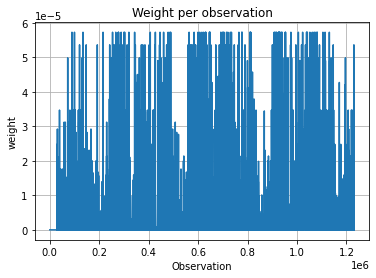

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.observation_weights_)), model.observation_weights_.values())

ax.set(xlabel='Observation', ylabel='weight',
       title='Weight per observation')
ax.grid()
plt.show()

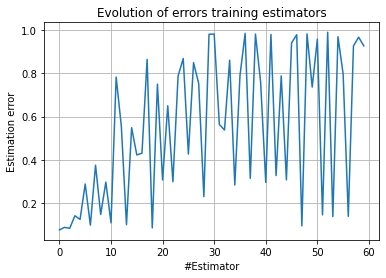

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

*Validate with implementation from sklearn*

In [13]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values

    model = AdaBoostClassifier(n_estimators=60, learning_rate=0.3, algorithm="SAMME").fit(X, y)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 95.02%
	LOS 2: Recall 34.86%
	LOS 3: Recall 51.75%
	LOS 4: Recall 18.1%
	LOS 5: Recall 0.0%
	LOS 6: Recall 61.64%
LINK 6
	LOS 1: Recall 98.69%
	LOS 2: Recall 0.34%
	LOS 3: Recall 70.59%
	LOS 4: Recall 17.99%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 7
	LOS 1: Recall 98.42%
	LOS 2: Recall 0.0%
	LOS 3: Recall 63.13%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
	LOS 1: Recall 99.31%
	LOS 2: Recall 0.0%
	LOS 3: Recall 81.69%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 36.38%
LINK 9
	LOS 1: Recall 95.64%
	LOS 2: Recall 64.34%
	LOS 3: Recall 47.04%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
	LOS 1: Recall 99.26%
	LOS 2: Recall 5.19%
	LOS 3: Recall 30.01%
	LOS 4: Recall 0.0%
	LOS 5: Recall 63.61%
	LOS 6: Recall 0.0%


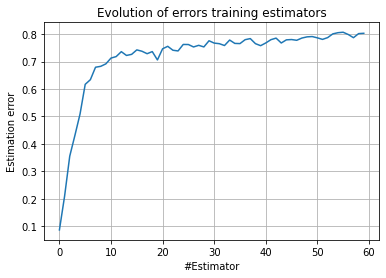

In [14]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

### **NO FEATURE ENGINEERING SAMME.R**

In [18]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME.R_nofeat_link{LINK}.joblib'

    # Max Depth = 3 because we have 6 possible classes (2^3=8 separable regions)
    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 95.3%
	LOS 2: Recall 40.44%
	LOS 3: Recall 52.18%
	LOS 4: Recall 14.73%
	LOS 5: Recall 18.28%
	LOS 6: Recall 53.81%
LINK 6
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.75%
	LOS 2: Recall 0.0%
	LOS 3: Recall 72.69%
	LOS 4: Recall 2.39%
	LOS 5: Recall 15.1%
	LOS 6: Recall 38.68%
LINK 7
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.68%
	LOS 2: Recall 31.5%
	LOS 3: Recall 58.31%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.68%
	LOS 2: Recall 0.0%
	LOS 3: Recall 69.66%
	LOS 4: Recall 19.38%
	LOS 5: Recall 3.5%
	LOS 6: Recall 42.93%
LINK 9
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 96.83%
	LOS 2: Recall 60.37%
	LOS 3: Recall 31.9%
	LOS 4: Recall 5.58%
	LOS 5: Recall 0.95%
	LOS 6: Recall 0.0%
LINK 10
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.3%
	LOS 2: Recall 4.66%
	LOS 3: Recall 26.27%
	LOS 4: Recall 23.99%
	LOS 5: Recall 42.57%


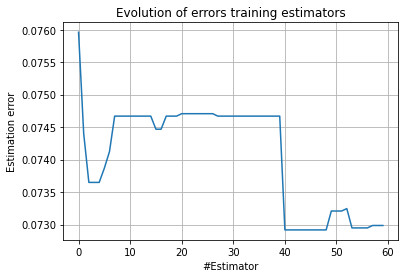

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

*Validate with implementation from sklearn*

In [20]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values

    model = AdaBoostClassifier(n_estimators=60, learning_rate=0.3, algorithm="SAMME.R").fit(X, y)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 95.02%
	LOS 2: Recall 44.26%
	LOS 3: Recall 52.38%
	LOS 4: Recall 14.73%
	LOS 5: Recall 18.28%
	LOS 6: Recall 54.04%
LINK 6
	LOS 1: Recall 98.75%
	LOS 2: Recall 0.0%
	LOS 3: Recall 73.74%
	LOS 4: Recall 0.0%
	LOS 5: Recall 20.86%
	LOS 6: Recall 0.0%
LINK 7
	LOS 1: Recall 97.79%
	LOS 2: Recall 29.95%
	LOS 3: Recall 60.02%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
	LOS 1: Recall 99.68%
	LOS 2: Recall 0.0%
	LOS 3: Recall 70.61%
	LOS 4: Recall 13.75%
	LOS 5: Recall 8.29%
	LOS 6: Recall 36.38%
LINK 9
	LOS 1: Recall 97.45%
	LOS 2: Recall 56.68%
	LOS 3: Recall 18.08%
	LOS 4: Recall 4.54%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
	LOS 1: Recall 99.48%
	LOS 2: Recall 0.0%
	LOS 3: Recall 23.94%
	LOS 4: Recall 23.99%
	LOS 5: Recall 38.63%
	LOS 6: Recall 39.36%


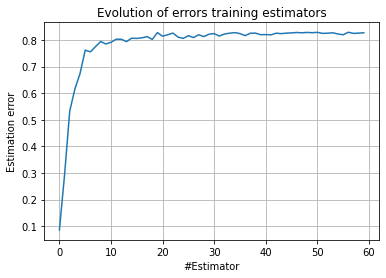

In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

### **NO FEATURE ENGINEERING M2**

In [25]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'/{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_M2_nofeat_link{LINK}.joblib'

    # Max Depth = 3 because we have 6 possible classes (2^3=8 separable regions)
    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of AdaBoost
	LOS 1: Recall 95.85%
	LOS 2: Recall 36.91%
	LOS 3: Recall 53.22%
	LOS 4: Recall 14.73%
	LOS 5: Recall 11.96%
	LOS 6: Recall 61.64%
LINK 6
M2 Implementation of AdaBoost
	LOS 1: Recall 98.75%
	LOS 2: Recall 0.0%
	LOS 3: Recall 73.74%
	LOS 4: Recall 0.0%
	LOS 5: Recall 20.86%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of AdaBoost
	LOS 1: Recall 97.74%
	LOS 2: Recall 31.28%
	LOS 3: Recall 58.31%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of AdaBoost
	LOS 1: Recall 99.68%
	LOS 2: Recall 0.0%
	LOS 3: Recall 69.5%
	LOS 4: Recall 23.34%
	LOS 5: Recall 0.0%
	LOS 6: Recall 36.38%
LINK 9
M2 Implementation of AdaBoost
	LOS 1: Recall 96.82%
	LOS 2: Recall 62.06%
	LOS 3: Recall 19.93%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of AdaBoost
	LOS 1: Recall 99.48%
	LOS 2: Recall 0.0%
	LOS 3: Recall 18.24%
	LOS 4: Recall 31.28%
	LOS 5: Recall 34.12%
	LOS 6: Recall 45.66%


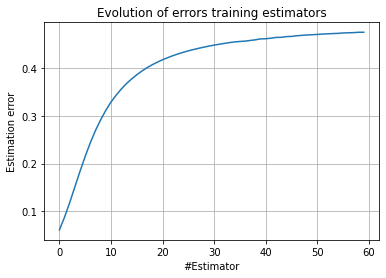

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

## Feature engineering SAMME

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [15]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of AdaBoost
	LOS 1: Recall 95.53%
	LOS 2: Recall 32.91%
	LOS 3: Recall 38.57%
	LOS 4: Recall 10.39%
	LOS 5: Recall 17.0%
	LOS 6: Recall 59.84%
LINK 6
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.51%
	LOS 2: Recall 6.14%
	LOS 3: Recall 67.94%
	LOS 4: Recall 6.97%
	LOS 5: Recall 23.18%
	LOS 6: Recall 32.32%
LINK 7
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.39%
	LOS 2: Recall 38.33%
	LOS 3: Recall 54.23%
	LOS 4: Recall 7.55%
	LOS 5: Recall 2.91%
	LOS 6: Recall 2.23%
LINK 8
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.46%
	LOS 2: Recall 18.5%
	LOS 3: Recall 68.26%
	LOS 4: Recall 13.61%
	LOS 5: Recall 12.21%
	LOS 6: Recall 38.09%
LINK 9
SAMME Implementation of AdaBoost
	LOS 1: Recall 96.37%
	LOS 2: Recall 61.72%
	LOS 3: Recall 30.83%
	LOS 4: Recall 10.99%
	LOS 5: Recall 25.87%
	LOS 6: Recall 0.0%
LINK 10
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.85%
	LOS 2: Recall 26.45%
	LOS 3: Recall 19.62%
	LOS 4: Recall 29.16%
	LOS 5: Recall 36.49

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [16]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
SAMME Implementation of AdaBoost
	LOS 1: Recall 95.34%
	LOS 2: Recall 45.66%
	LOS 3: Recall 34.62%
	LOS 4: Recall 15.17%
	LOS 5: Recall 19.22%
	LOS 6: Recall 52.03%
LINK 6
SAMME Implementation of AdaBoost
	LOS 1: Recall 98.41%
	LOS 2: Recall 7.34%
	LOS 3: Recall 70.79%
	LOS 4: Recall 11.14%
	LOS 5: Recall 23.02%
	LOS 6: Recall 28.12%
LINK 7
SAMME Implementation of AdaBoost
	LOS 1: Recall 97.4%
	LOS 2: Recall 39.68%
	LOS 3: Recall 54.27%
	LOS 4: Recall 5.95%
	LOS 5: Recall 1.01%
	LOS 6: Recall 3.14%
LINK 8
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.41%
	LOS 2: Recall 20.74%
	LOS 3: Recall 71.75%
	LOS 4: Recall 12.36%
	LOS 5: Recall 8.96%
	LOS 6: Recall 39.81%
LINK 9
SAMME Implementation of AdaBoost
	LOS 1: Recall 96.8%
	LOS 2: Recall 60.56%
	LOS 3: Recall 24.41%
	LOS 4: Recall 20.51%
	LOS 5: Recall 24.61%
	LOS 6: Recall 0.0%
LINK 10
SAMME Implementation of AdaBoost
	LOS 1: Recall 99.22%
	LOS 2: Recall 5.93%
	LOS 3: Recall 28.88%
	LOS 4: Reca

## Feature engineering SAMME.R

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [22]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME.R_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 96.03%
	LOS 2: Recall 32.78%
	LOS 3: Recall 35.91%
	LOS 4: Recall 10.91%
	LOS 5: Recall 14.3%
	LOS 6: Recall 42.98%
LINK 6
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.53%
	LOS 2: Recall 2.42%
	LOS 3: Recall 74.6%
	LOS 4: Recall 3.55%
	LOS 5: Recall 14.42%
	LOS 6: Recall 21.12%
LINK 7
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.78%
	LOS 2: Recall 34.51%
	LOS 3: Recall 58.88%
	LOS 4: Recall 2.08%
	LOS 5: Recall 2.6%
	LOS 6: Recall 2.88%
LINK 8
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.54%
	LOS 2: Recall 8.62%
	LOS 3: Recall 72.52%
	LOS 4: Recall 10.48%
	LOS 5: Recall 7.58%
	LOS 6: Recall 48.81%
LINK 9
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.27%
	LOS 2: Recall 57.85%
	LOS 3: Recall 31.0%
	LOS 4: Recall 7.29%
	LOS 5: Recall 8.52%
	LOS 6: Recall 0.0%
LINK 10
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.24%
	LOS 2: Recall 5.17%
	LOS 3: Recall 25.49%
	LOS 4: Recall 22.26%
	LOS 5: Recall 

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [23]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME.R_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 95.71%
	LOS 2: Recall 34.38%
	LOS 3: Recall 37.58%
	LOS 4: Recall 11.92%
	LOS 5: Recall 13.05%
	LOS 6: Recall 39.58%
LINK 6
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 98.41%
	LOS 2: Recall 2.5%
	LOS 3: Recall 75.53%
	LOS 4: Recall 4.71%
	LOS 5: Recall 13.96%
	LOS 6: Recall 17.15%
LINK 7
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.83%
	LOS 2: Recall 36.35%
	LOS 3: Recall 55.95%
	LOS 4: Recall 3.27%
	LOS 5: Recall 2.29%
	LOS 6: Recall 6.94%
LINK 8
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.53%
	LOS 2: Recall 15.03%
	LOS 3: Recall 72.42%
	LOS 4: Recall 15.4%
	LOS 5: Recall 6.21%
	LOS 6: Recall 47.89%
LINK 9
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 97.17%
	LOS 2: Recall 58.83%
	LOS 3: Recall 32.42%
	LOS 4: Recall 12.74%
	LOS 5: Recall 3.89%
	LOS 6: Recall 0.0%
LINK 10
SAMME.R Implementation of AdaBoost
	LOS 1: Recall 99.16%
	LOS 2: Recall 6.21%
	LOS 3: Recall 32.59%
	L

## Feature engineering M2

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [27]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_M2_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of AdaBoost
	LOS 1: Recall 95.87%
	LOS 2: Recall 30.03%
	LOS 3: Recall 47.86%
	LOS 4: Recall 14.73%
	LOS 5: Recall 11.96%
	LOS 6: Recall 61.64%
LINK 6
M2 Implementation of AdaBoost
	LOS 1: Recall 98.68%
	LOS 2: Recall 0.0%
	LOS 3: Recall 75.76%
	LOS 4: Recall 0.0%
	LOS 5: Recall 20.29%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of AdaBoost
	LOS 1: Recall 97.64%
	LOS 2: Recall 35.77%
	LOS 3: Recall 58.21%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of AdaBoost
	LOS 1: Recall 99.44%
	LOS 2: Recall 9.62%
	LOS 3: Recall 73.16%
	LOS 4: Recall 15.74%
	LOS 5: Recall 0.0%
	LOS 6: Recall 48.11%
LINK 9
M2 Implementation of AdaBoost
	LOS 1: Recall 97.21%
	LOS 2: Recall 60.35%
	LOS 3: Recall 22.55%
	LOS 4: Recall 0.83%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of AdaBoost
	LOS 1: Recall 99.46%
	LOS 2: Recall 1.82%
	LOS 3: Recall 23.96%
	LOS 4: Recall 23.99%
	LOS 5: Recall 34.12%
	LOS 6: Recall 45.66%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [28]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/AdaBoost_{PREDICTED_MINUTES_AHEAD}m_M2_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = AdaBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
M2 Implementation of AdaBoost
	LOS 1: Recall 95.86%
	LOS 2: Recall 29.99%
	LOS 3: Recall 47.94%
	LOS 4: Recall 14.73%
	LOS 5: Recall 11.96%
	LOS 6: Recall 61.64%
LINK 6
M2 Implementation of AdaBoost
	LOS 1: Recall 98.68%
	LOS 2: Recall 0.0%
	LOS 3: Recall 75.72%
	LOS 4: Recall 0.0%
	LOS 5: Recall 20.29%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of AdaBoost
	LOS 1: Recall 97.65%
	LOS 2: Recall 35.34%
	LOS 3: Recall 58.74%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of AdaBoost
	LOS 1: Recall 99.58%
	LOS 2: Recall 5.8%
	LOS 3: Recall 72.99%
	LOS 4: Recall 16.02%
	LOS 5: Recall 0.0%
	LOS 6: Recall 48.11%
LINK 9
M2 Implementation of AdaBoost
	LOS 1: Recall 97.22%
	LOS 2: Recall 60.32%
	LOS 3: Recall 22.6%
	LOS 4: Recall 1.44%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of AdaBoost
	LOS 1: Recall 99.44%
	LOS 2: Recall 0.35%
	LOS 3: Recall 28.77%
	LOS 4: Recall 30.81%
	LOS 5: Recall 34.12%

# **RUSBoost**

### *Algorithms*

**Algorithm implementation SAMME**

In [29]:
def labelToIndex(i,clf):
    return clf.labelDict[i]

def indexToLabel(i,clf):
    return clf.classes[i]

class RUSBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("SAMME Implementation of RUSBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = [None]*n_estimators
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """
        
        # Initialize observation weights as 1/N where N is total `n_samples`
        N = df.shape[0]
        w = {epoch: 1/N for epoch in df.index}
        
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        undersampling_n = min(df[y_column].value_counts())

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        y = df[y_column].values
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):
            
        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                # Quizas muestrear usando la inversa de los pesos (.sample(weights=1/w)) para hacer overfit en los casos con menos error == underfit
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])
            
            # Indices are dates in integer format
            w_ = np.array([w[epoch] for epoch in df_.index])

            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=w_).predict
        
        # 3) Error-rate computation
            incorrect = Gm(X) != y
            errM = np.average(incorrect,weights=list(w.values()),axis=0)
            self.estimator_errors_.append(errM)
        
        # 4) WeakLearner weight for ensemble computation [errM < (k-1)/k]
            BetaM = np.log((1-errM)/errM)+np.log(k-1)            
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            w_ = np.array(list(w.values()))
            positive_mask = w_ > 0
            w_ *= np.exp(self.learning_rate* BetaM*(incorrect * positive_mask))
            for i, epoch in enumerate(w.keys()):
                w[epoch] = w_[i]
                norm_ += w_[i]
            for epoch in w.keys():
                w[epoch] /= norm_
        
        self.observation_weights_ = w
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i

    def predict(self,X):
        k = len(self.classes)
        Bms_ = [Bm for Bm,_ in self.models]
        prob_matrix = np.full((X.shape[0],k), -sum(Bms_)/(k-1))
        
        # Obtain the predicted index array with shape (#obs,#weak_learners)
        iTL = np.vectorize(labelToIndex)
        y_pred = np.stack([iTL(Gm(X),self) for _,Gm in self.models], axis=-1)

        # Weight the indices count using Bm associated to each weak_learner
        prob_matrix += np.apply_along_axis(lambda x: np.bincount(x, weights=Bms_, minlength=k), axis=1, arr=y_pred)*k/(k-1)
        
        iTL = np.vectorize(indexToLabel)
        return iTL(np.argmax(prob_matrix,axis=1),self)

**Algorithm implementation M2**

In [35]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class RUSBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("M2 Implementation of RUSBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(df[y_column].value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the numebr of classes
        N = df.shape[0]
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in df.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        y = df[y_column].values
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y,self)
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                # Quizas muestrear usando la inversa de los pesos (.sample(weights=1/w)) para hacer overfit en los casos con menos error == underfit
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])

            
            # Training data initalization
            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 3) Error-rate computation
            predictions_proba = Gm(X)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_
        
        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)


### **NO FEATURE ENGINEERING SAMME**

In [30]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_nofeat_link{LINK}.joblib'

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of RUSBoost
	LOS 1: Recall 81.25%
	LOS 2: Recall 69.77%
	LOS 3: Recall 31.89%
	LOS 4: Recall 21.31%
	LOS 5: Recall 35.88%
	LOS 6: Recall 71.31%
LINK 6
SAMME Implementation of RUSBoost
	LOS 1: Recall 80.93%
	LOS 2: Recall 62.71%
	LOS 3: Recall 50.12%
	LOS 4: Recall 0.05%
	LOS 5: Recall 51.89%
	LOS 6: Recall 56.3%
LINK 7
SAMME Implementation of RUSBoost
	LOS 1: Recall 90.44%
	LOS 2: Recall 34.92%
	LOS 3: Recall 50.24%
	LOS 4: Recall 3.29%
	LOS 5: Recall 35.47%
	LOS 6: Recall 33.51%
LINK 8
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.05%
	LOS 2: Recall 42.94%
	LOS 3: Recall 71.23%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 77.28%
LINK 9
SAMME Implementation of RUSBoost
	LOS 1: Recall 92.8%
	LOS 2: Recall 60.61%
	LOS 3: Recall 49.3%
	LOS 4: Recall 3.71%
	LOS 5: Recall 39.33%
	LOS 6: Recall 32.01%
LINK 10
SAMME Implementation of RUSBoost
	LOS 1: Recall 90.03%
	LOS 2: Recall 58.53%
	LOS 3: Recall 38.25%
	LOS 4: Recall 19.16%
	LOS 5: Recall 31.81%

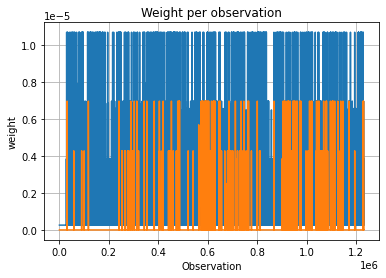

In [31]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(model.observation_weights_)), model.observation_weights_.values())

tmp = training_df[training_df['link_id'] == LINK]
ax.plot(np.arange(len(model.observation_weights_)), np.array(list(model.observation_weights_.values()))*np.array(tmp['LOS_dep'] == 6).astype(np.int8).astype(np.int8))

ax.set(xlabel='Observation', ylabel='weight',
       title='Weight per observation')
ax.grid()
plt.show()

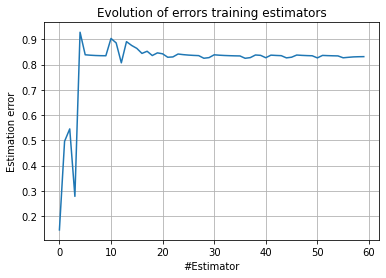

In [32]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

### **NO FEATURE ENGINEERING M2**

In [36]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_nofeat_link{LINK}.joblib'

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], 'tt_arr$', 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of RUSBoost
	LOS 1: Recall 82.76%
	LOS 2: Recall 55.52%
	LOS 3: Recall 36.86%
	LOS 4: Recall 25.56%
	LOS 5: Recall 31.32%
	LOS 6: Recall 71.82%
LINK 6
M2 Implementation of RUSBoost
	LOS 1: Recall 80.93%
	LOS 2: Recall 63.04%
	LOS 3: Recall 45.37%
	LOS 4: Recall 43.58%
	LOS 5: Recall 30.67%
	LOS 6: Recall 50.88%
LINK 7
M2 Implementation of RUSBoost
	LOS 1: Recall 83.22%
	LOS 2: Recall 66.78%
	LOS 3: Recall 48.01%
	LOS 4: Recall 12.74%
	LOS 5: Recall 1.82%
	LOS 6: Recall 59.03%
LINK 8
M2 Implementation of RUSBoost
	LOS 1: Recall 90.43%
	LOS 2: Recall 59.42%
	LOS 3: Recall 67.79%
	LOS 4: Recall 4.57%
	LOS 5: Recall 32.75%
	LOS 6: Recall 42.93%
LINK 9
M2 Implementation of RUSBoost
	LOS 1: Recall 88.92%
	LOS 2: Recall 67.32%
	LOS 3: Recall 53.43%
	LOS 4: Recall 45.16%
	LOS 5: Recall 31.02%
	LOS 6: Recall 32.01%
LINK 10
M2 Implementation of RUSBoost
	LOS 1: Recall 90.03%
	LOS 2: Recall 59.21%
	LOS 3: Recall 27.45%
	LOS 4: Recall 28.76%
	LOS 5: Recall 30.38%
	LOS 6: R

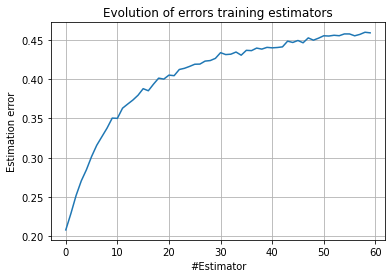

In [37]:
fig, ax = plt.subplots()
ax.plot(np.arange(model.n_estimators), model.estimator_errors_)

ax.set(xlabel='#Estimator', ylabel='Estimation error',
       title='Evolution of errors training estimators')
ax.grid()
plt.show()

## Feature engineering SAMME

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [33]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
SAMME Implementation of RUSBoost
	LOS 1: Recall 82.84%
	LOS 2: Recall 68.21%
	LOS 3: Recall 39.19%
	LOS 4: Recall 25.55%
	LOS 5: Recall 44.74%
	LOS 6: Recall 63.68%
LINK 6
SAMME Implementation of RUSBoost
	LOS 1: Recall 85.98%
	LOS 2: Recall 46.68%
	LOS 3: Recall 59.71%
	LOS 4: Recall 36.98%
	LOS 5: Recall 41.17%
	LOS 6: Recall 40.61%
LINK 7
SAMME Implementation of RUSBoost
	LOS 1: Recall 88.23%
	LOS 2: Recall 48.77%
	LOS 3: Recall 52.69%
	LOS 4: Recall 22.38%
	LOS 5: Recall 6.67%
	LOS 6: Recall 58.12%
LINK 8
SAMME Implementation of RUSBoost
	LOS 1: Recall 91.29%
	LOS 2: Recall 39.19%
	LOS 3: Recall 75.84%
	LOS 4: Recall 9.06%
	LOS 5: Recall 26.62%
	LOS 6: Recall 30.27%
LINK 9
SAMME Implementation of RUSBoost
	LOS 1: Recall 86.37%
	LOS 2: Recall 83.1%
	LOS 3: Recall 1.78%
	LOS 4: Recall 6.15%
	LOS 5: Recall 28.6%
	LOS 6: Recall 38.53%
LINK 10
SAMME Implementation of RUSBoost
	LOS 1: Recall 90.95%
	LOS 2: Recall 57.71%
	LOS 3: Recall 8.58%
	LOS 4: Recall 38.16%
	LOS 5: Recall 8.5

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [34]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_SAMME_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
SAMME Implementation of RUSBoost
	LOS 1: Recall 84.37%
	LOS 2: Recall 46.76%
	LOS 3: Recall 49.47%
	LOS 4: Recall 22.08%
	LOS 5: Recall 45.35%
	LOS 6: Recall 58.17%
LINK 6
SAMME Implementation of RUSBoost
	LOS 1: Recall 87.37%
	LOS 2: Recall 50.77%
	LOS 3: Recall 34.46%
	LOS 4: Recall 53.72%
	LOS 5: Recall 1.94%
	LOS 6: Recall 65.99%
LINK 7
SAMME Implementation of RUSBoost
	LOS 1: Recall 87.6%
	LOS 2: Recall 67.3%
	LOS 3: Recall 29.97%
	LOS 4: Recall 33.87%
	LOS 5: Recall 1.4%
	LOS 6: Recall 61.65%
LINK 8
SAMME Implementation of RUSBoost
	LOS 1: Recall 91.55%
	LOS 2: Recall 40.43%
	LOS 3: Recall 70.71%
	LOS 4: Recall 37.15%
	LOS 5: Recall 2.25%
	LOS 6: Recall 42.36%
LINK 9
SAMME Implementation of RUSBoost
	LOS 1: Recall 86.37%
	LOS 2: Recall 56.62%
	LOS 3: Recall 58.59%
	LOS 4: Recall 42.58%
	LOS 5: Recall 0.0%
	LOS 6: Recall 60.62%
LINK 10
SAMME Implementation of RUSBoost
	LOS 1: Recall 93.16%
	LOS 2: Recall 22.09%
	LOS 3: Recall 23.25%
	LOS 4: Re

## Feature engineering M2

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [38]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_adjacent_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of RUSBoost
	LOS 1: Recall 83.16%
	LOS 2: Recall 56.94%
	LOS 3: Recall 41.8%
	LOS 4: Recall 21.69%
	LOS 5: Recall 39.41%
	LOS 6: Recall 67.75%
LINK 6
M2 Implementation of RUSBoost
	LOS 1: Recall 79.53%
	LOS 2: Recall 69.44%
	LOS 3: Recall 42.52%
	LOS 4: Recall 49.9%
	LOS 5: Recall 31.09%
	LOS 6: Recall 52.04%
LINK 7
M2 Implementation of RUSBoost
	LOS 1: Recall 81.95%
	LOS 2: Recall 70.25%
	LOS 3: Recall 34.66%
	LOS 4: Recall 30.71%
	LOS 5: Recall 12.52%
	LOS 6: Recall 58.64%
LINK 8
M2 Implementation of RUSBoost
	LOS 1: Recall 88.5%
	LOS 2: Recall 58.19%
	LOS 3: Recall 70.09%
	LOS 4: Recall 18.19%
	LOS 5: Recall 31.42%
	LOS 6: Recall 52.99%
LINK 9
M2 Implementation of RUSBoost
	LOS 1: Recall 85.97%
	LOS 2: Recall 71.78%
	LOS 3: Recall 54.69%
	LOS 4: Recall 42.71%
	LOS 5: Recall 26.29%
	LOS 6: Recall 26.06%
LINK 10
M2 Implementation of RUSBoost
	LOS 1: Recall 90.31%
	LOS 2: Recall 60.18%
	LOS 3: Recall 26.1%
	LOS 4: Recall 28.76%
	LOS 5: Recall 27.36%
	LOS 6: Rec

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [39]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/RUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
M2 Implementation of RUSBoost
	LOS 1: Recall 83.32%
	LOS 2: Recall 55.64%
	LOS 3: Recall 43.16%
	LOS 4: Recall 21.56%
	LOS 5: Recall 40.82%
	LOS 6: Recall 67.03%
LINK 6
M2 Implementation of RUSBoost
	LOS 1: Recall 80.48%
	LOS 2: Recall 68.11%
	LOS 3: Recall 43.64%
	LOS 4: Recall 52.19%
	LOS 5: Recall 29.64%
	LOS 6: Recall 53.33%
LINK 7
M2 Implementation of RUSBoost
	LOS 1: Recall 81.84%
	LOS 2: Recall 69.98%
	LOS 3: Recall 34.65%
	LOS 4: Recall 32.09%
	LOS 5: Recall 6.86%
	LOS 6: Recall 60.47%
LINK 8
M2 Implementation of RUSBoost
	LOS 1: Recall 87.99%
	LOS 2: Recall 56.26%
	LOS 3: Recall 67.67%
	LOS 4: Recall 22.05%
	LOS 5: Recall 29.83%
	LOS 6: Recall 53.12%
LINK 9
M2 Implementation of RUSBoost
	LOS 1: Recall 85.96%
	LOS 2: Recall 71.19%
	LOS 3: Recall 54.66%
	LOS 4: Recall 35.3%
	LOS 5: Recall 26.5%
	LOS 6: Recall 25.21%
LINK 10
M2 Implementation of RUSBoost
	LOS 1: Recall 90.18%
	LOS 2: Recall 59.3%
	LOS 3: Recall 25.15%
	LOS 4: Recall 32.16%
	L

# **Modified RUSBoost**

### *Algorithms*

**Algorithm implementation M2**

In [40]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class ModifiedRUSBoostClassifier_:
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        print("M2 Implementation of MODIFIED RUSBoost")
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, )
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(df[y_column]))
        k = len(self.classes)
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(df[y_column].value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the number of classes
        N = df.shape[0]
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in df.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        y = df[y_column].values
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y,self)
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                _df_label_ = df[ df[y_column]==label_ ]
                if len(_df_label_) <= undersampling_n:
                    df_ = pd.concat([ df_, df[ df[y_column]==label_ ] ])
                else:
                    # Order weights array in decreasing order to select the first `undersampling_n` elements
                    _D_ = {epoch: weight for epoch, weight in D.items() if epoch in _df_label_.index}
                    _D_ = [epoch for epoch,_ in sorted(_D_.items(), key = lambda x: sum(itemgetter(1)(x)), reverse = True)[:undersampling_n]]
                    df_ = pd.concat([ df_, _df_label_.loc[_D_] ])

            
            # Training data initalization
            X_ = df_.filter(regex=(X_columns)).values
            y_ = df_[y_column].values
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 3) Error-rate computation
            predictions_proba = Gm(X)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_

        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)

### **NO FEATURE ENGINEERING M2**

In [41]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/ModifiedRUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_nofeat_link{LINK}.joblib'

    model = ModifiedRUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], "tt_arr$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1)
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 95.64%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 9.4%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 6
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 81.75%
	LOS 2: Recall 23.54%
	LOS 3: Recall 46.03%
	LOS 4: Recall 47.83%
	LOS 5: Recall 0.0%
	LOS 6: Recall 1.17%
LINK 7
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 91.03%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.11%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 95.72%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.06%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 97.59%
	LOS 2: Recall 1.03%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 95.62%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.24%
	LOS 5: Recall 0.0%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

In [42]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/ModifiedRUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_adjacent_linkm_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = ModifiedRUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_ar[^-]+$", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_ar[^-]+$")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_ar[^-]+$")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 20.83%
	LOS 2: Recall 4.52%
	LOS 3: Recall 24.95%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 6
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 18.48%
	LOS 2: Recall 54.24%
	LOS 3: Recall 81.02%
	LOS 4: Recall 0.0%
	LOS 5: Recall 39.65%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 28.76%
	LOS 2: Recall 1.42%
	LOS 3: Recall 1.13%
	LOS 4: Recall 60.8%
	LOS 5: Recall 50.58%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 92.43%
	LOS 2: Recall 0.08%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 10.95%
	LOS 2: Recall 10.19%
	LOS 3: Recall 25.92%
	LOS 4: Recall 71.64%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 94.02%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.04%
	LOS 5: R

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [43]:
print(f'USING PREVIOUS {INPUT_MINUTES_BEFORE}m INFORMATION')
for LINK in range(5,11):
    print(f"LINK {LINK}")
    filename = f'{ROOT}/models/ModifiedRUSBoost_{PREDICTED_MINUTES_AHEAD}m_M2_temp{INPUT_MINUTES_BEFORE}m_link{LINK}.joblib'

    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = ModifiedRUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=60, learning_rate=0.3).fit(training_df_link, "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = validation_df_link.filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

USING PREVIOUS 45m INFORMATION
LINK 5
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 97.37%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.01%
	LOS 4: Recall 7.47%
	LOS 5: Recall 0.36%
	LOS 6: Recall 0.0%
LINK 6
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 14.95%
	LOS 2: Recall 66.08%
	LOS 3: Recall 76.78%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 7
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 31.7%
	LOS 2: Recall 2.22%
	LOS 3: Recall 10.41%
	LOS 4: Recall 26.95%
	LOS 5: Recall 40.08%
	LOS 6: Recall 0.0%
LINK 8
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 92.09%
	LOS 2: Recall 0.08%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 19.95%
	LOS 2: Recall 24.11%
	LOS 3: Recall 50.27%
	LOS 4: Recall 64.22%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of MODIFIED RUSBoost
	LOS 1: Recall 97.27%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%


# **LSTM**

Chosen number of LSTM units equal to number of classes to directly obtain number of classes predictions, and attach a same dimensionality Dense layer that combines each class prediction. This can be useful to compensate for possible class imbalance. https://tung2389.github.io/coding-note/unitslstm

### **NO FEATURE ENGINEERING**

**TRAIN or LOAD switch**

In [9]:
train_again = False

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    #Correctly order the sequence [X(t-N),...,X(t)]
    X = np.flip(X, 1)
    # Min-Max Scaling
    sc = preprocessing.MinMaxScaler().fit(np.array([[X[:,-1].max()]*X.shape[1], [X[:,-1].min()]*X.shape[1]]))
    
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    y = np.expand_dims(y, axis=1)

    onehot_encoder = preprocessing.OneHotEncoder()
    y = onehot_encoder.fit_transform(y).toarray()
    
    if train_again:
        X = sc.transform(X)
        X = np.expand_dims(X, axis=2)

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=64-num_features,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=256, validation_split=0, verbose=0)

        model.save(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values )
        X_test = np.flip(X_test, 1)
        X_test = np.expand_dims(X_test, axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

LINK 5
17716/17716 [==============================] - 54s 3ms/step
	LOS 1: Recall 96.97%
2564/2564 [==============================] - 9s 3ms/step
	LOS 2: Recall 41.61%
1646/1646 [==============================] - 5s 3ms/step
	LOS 3: Recall 45.58%
635/635 [==============================] - 2s 3ms/step
	LOS 4: Recall 15.32%
322/322 [==============================] - 1s 3ms/step
	LOS 5: Recall 22.69%
247/247 [==============================] - 1s 3ms/step
	LOS 6: Recall 58.86%
LINK 6
19746/19746 [==============================] - 65s 3ms/step
	LOS 1: Recall 98.71%
1299/1299 [==============================] - 4s 3ms/step
	LOS 2: Recall 12.12%
1464/1464 [==============================] - 5s 3ms/step
	LOS 3: Recall 66.77%
425/425 [==============================] - 1s 3ms/step
	LOS 4: Recall 9.74%
142/142 [==============================] - 0s 3ms/step
	LOS 5: Recall 15.19%
54/54 [==============================] - 0s 4ms/step
	LOS 6: Recall 25.9%
LINK 7
19654/19654 [============================

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

**TRAIN or LOAD switch**

In [ ]:
train_again = False

In [6]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)

    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling per Link
    sc = {}
    sc[LINK] = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    X = sc[LINK].transform(X)
    X = np.expand_dims(X, axis=2)

    for other_link in other_links:
        temp = training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
        sc[other_link] = preprocessing.MinMaxScaler().fit(np.array([[temp[:,0].max()]*temp.shape[1], [temp[:,0].min()]*temp.shape[1]]))
        temp = sc[other_link].transform(temp)
        X = np.concatenate( (X, np.expand_dims(temp, axis=2)) , axis=2)
    #Correctly order the sequence [X(t-N),...,X(t)]
    X = np.flip(X, 1)
    
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    y = np.expand_dims(y, axis=1)

    onehot_encoder = preprocessing.OneHotEncoder()
    y = onehot_encoder.fit_transform(y).toarray()
        
    if train_again:
        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=64-num_features,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=256, validation_split=0, verbose=0)

        model.save(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    for LOS in range(1,7):        
        X_test = sc[LINK].transform( validation_df[validation_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)

        for other_link in other_links:
            temp = validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
            temp = sc[other_link].transform(temp)
            X_test = np.concatenate( (X_test, np.expand_dims(temp, axis=2)) , axis=2)
        X_test = np.flip(X_test, 1)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

LINK 5
23129/23129 [==============================] - 59s 3ms/step
	LOS 1: Recall 82.83%
23129/23129 [==============================] - 59s 3ms/step
	LOS 2: Recall 7.17%
23129/23129 [==============================] - 59s 3ms/step
	LOS 3: Recall 6.94%
23129/23129 [==============================] - 59s 3ms/step
	LOS 4: Recall 1.47%
23129/23129 [==============================] - 59s 3ms/step
	LOS 5: Recall 0.93%
23129/23129 [==============================] - 59s 3ms/step
	LOS 6: Recall 0.66%
LINK 6
23129/23129 [==============================] - 60s 3ms/step
	LOS 1: Recall 90.56%
23129/23129 [==============================] - 59s 3ms/step
	LOS 2: Recall 1.53%
23129/23129 [==============================] - 59s 3ms/step
	LOS 3: Recall 6.83%
23129/23129 [==============================] - 59s 3ms/step
	LOS 4: Recall 0.65%
23129/23129 [==============================] - 59s 3ms/step
	LOS 5: Recall 0.34%
23129/23129 [==============================] - 59s 3ms/step
	LOS 6: Recall 0.08%
LINK 7
23129

### **FEATURE ENGINEERING CLASS BALANCING BY RUS**

https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
Stochastic Gradient descent increases variance but avoids local minima. A Boosting of high variance LSTM can reduce this variance.

# **LSTM Stacked**

Determine number of hidden units in first LSTM (don't want to sparse the hidden units space much more than the features space)
units = highestPowerof2(num_features+1)

In [ ]:
def highestPowerof2(n):
    for i in range(n, 0, -1):
        if ((i & (i - 1)) == 0): return i;

## **NO FEATURE ENGINEERING**

**TRAIN or LOAD switch**

In [ ]:
train_again = False

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling
    sc = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    
    if train_again:
        X = sc.transform(X)
        X = np.expand_dims(X, axis=2)
        print(f'Size of training data array {X.shape}')
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=highestPowerof2(num_features+1),
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=num_out,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0, verbose=0)

        model.save(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_nofeat_link{LINK}.h5')
    
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

**TRAIN or LOAD switch**

In [ ]:
train_again = False

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)

    X = training_df[training_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values
    # Min-Max Scaling per Link
    sc = {}
    sc[LINK] = preprocessing.MinMaxScaler().fit(np.array([[X[:,0].max()]*X.shape[1], [X[:,0].min()]*X.shape[1]]))
    X = sc[LINK].transform(X)
    X = np.expand_dims(X, axis=2)

    for other_link in other_links:
        temp = training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
        sc[other_link] = preprocessing.MinMaxScaler().fit(np.array([[temp[:,0].max()]*temp.shape[1], [temp[:,0].min()]*temp.shape[1]]))
        temp = sc[other_link].transform(temp)
        X = np.concatenate( (X, np.expand_dims(temp, axis=2)) , axis=2)
        
    if train_again:
        print(f'Size of training data array {X.shape}')
        y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()
        
        model.add(keras.layers.LSTM(
                input_shape=(int(INPUT_MINUTES_BEFORE/5)+1, num_features),
                units=highestPowerof2(num_features+1),
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=num_out,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=num_out, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0, verbose=1)

        model.save(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    else:
        model = keras.models.load_model(f'{ROOT}/models/LSTM_Stacked_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_adjacent_link{LINK}.h5')
    
    for LOS in range(1,7):        
        X_test = sc[LINK].transform( validation_df[validation_df['link_id'] == LINK].filter(regex=("tt_arr.*")).values )
        X_test = np.expand_dims(X_test, axis=2)

        for other_link in other_links:
            temp = validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")).values
            temp = sc[other_link].transform(temp)
            X_test = np.concatenate( (X_test, np.expand_dims(temp, axis=2)) , axis=2)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

# **LSTM RUSBoost**

### *Algorithms*

**Algorithm implementation M2**

In [4]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class LSTMRUSBoostClassifier_:
    
    def __init__(self, sequence_length: int, n_lstm=50, learning_rate=1.0):
        """
        param sequence_length: Length of each feature sequence. sequence_length = N in the feature sample [x(t),...,x(t-N)]
        """
        print("M2 Implementation of LSTM RUSBoost")
        self.n_lstm = n_lstm
        self.learning_rate = learning_rate
        self.models = []
        self.scaler = []
        self.onehot_encoder = preprocessing.OneHotEncoder
        self.sequence_length = sequence_length
        self.estimator_errors_ = []
        self.observation_weights_ = {}

    def fit(self, df: pd.DataFrame, X_columns: str, y_column: str):
        """
        param df: Training dataframe with shape (n_samples, ). Sample sequence order is expected to be received as [x(t),...,x(t-N)]
        param X_columns: pattern matching DataFrame column names that contain the features
        param y_column: name of DataFrame column name with the labels
        """        
        
        # Class labels mapping to internal indices ('lab1'->0, 'lab2'->1,...'labN'->N)
        self.createLabelDict(np.unique(df[y_column]))
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(df[y_column].value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the number of classes
        N = df.shape[0]
        k = len(self.classes)
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in df.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        X = df.filter(regex=(X_columns)).values
        if X.shape[1] == self.sequence_length:
            X = np.expand_dims(X, axis=2)
        elif X.shape[1] % self.sequence_length == 0:
            X = X.reshape((X.shape[0],self.sequence_length,int(X.shape[0]/self.sequence_length)), order='F')
        else:
            print("The length of all feature sequences must be the same")
        #Correctly order the sequence [X(t-N),...,X(t)]
        X = np.flip(X, 1)

        # Initialize input scaler for each feature
        for feature in range(X.shape[2]):
            self.scaler.append( preprocessing.MinMaxScaler().fit(np.array([[X[:,-1,feature].max()]*self.sequence_length, [X[:,-1,feature].min()]*self.sequence_length])) )
            X[:,:,feature] = self.scaler[feature].transform(X[:,:,feature])
        
        # Initialize output one-hot vector encoder
        y = df[y_column].values
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y,self)
        self.onehot_encoder = self.onehot_encoder().fit(np.expand_dims(y, axis=1))
        
        # M iterations (#WeakLearners)
        for m in range(self.n_lstm):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                df_ = pd.concat([ df_, df[ df[y_column]==label_ ].sample(undersampling_n, replace=False) ])
            
            # Training data initalization
            X_ = df_.filter(regex=(X_columns)).values
            if X_.shape[1] == self.sequence_length:
                X_ = np.expand_dims(X_, axis=2)
            elif X_.shape[1] % self.sequence_length == 0:
                X_ = X_.reshape((X_.shape[0],self.sequence_length,int(X_.shape[0]/self.sequence_length)), order='F')
            # Scale inputs
            for feature in range(X_.shape[2]):
                X_[:,:,feature] = self.scaler[feature].transform(X_[:,:,feature])
            #Correctly order the sequence [X(t-N),...,X(t)]
            X_ = np.flip(X_, 1)

            y_ = df_[y_column].values
            y_ = self.onehot_encoder.transform(np.expand_dims(y_, axis=1)).toarray()
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) LSTM training
            num_features = X_.shape[2]
            num_out = y_.shape[1]

            model = keras.models.Sequential()

            model.add(keras.layers.LSTM(
                    input_shape=(self.sequence_length, num_features),
                    units=32,
                    return_sequences=False))
            model.add(keras.layers.Dropout(0.2))

            model.add(keras.layers.Dense(units=num_out, activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.fit(X_, y_, sample_weight=D_, epochs=5, batch_size=32, validation_split=0, verbose=0)
        
        # 3) Error-rate computation
            predictions_proba = model.predict(X,verbose=None)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models.append( (BetaM,model.predict) )

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_

        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        if X.shape[1] == self.sequence_length:
            X = np.expand_dims(X, axis=2)
        elif X.shape[1] % self.sequence_length == 0:
            X = X.reshape((X.shape[0],self.sequence_length,int(X.shape[0]/self.sequence_length)), order='F')
        else:
            print("The length of all feature sequences must be the same")
        
        # Scale inputs
        for feature in range(X.shape[2]):
            X[:,:,feature] = self.scaler[feature].transform(X[:,:,feature])
        
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X,verbose=None) for Bm,Gm in self.models], axis=-1), axis=-1)
        return self.onehot_encoder.inverse_transform(sum_model_hypothesis)

### **NO FEATURE ENGINEERING M2**

In [5]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    
    filename = f'{ROOT}/models/LSTM-RUSBoost_{PREDICTED_MINUTES_AHEAD}m_horizon_{INPUT_MINUTES_BEFORE}m_M2_nofeat_link{LINK}.joblib'

    model = LSTMRUSBoostClassifier_(sequence_length=int(INPUT_MINUTES_BEFORE/5)+1, n_lstm=30, learning_rate=0.3).fit(training_df[training_df['link_id'] == LINK], "tt_arr.*", 'LOS_dep')
    joblib.dump(model, filename)

    for LOS in range(1,7):
        X_test = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].filter(regex=("tt_arr.*")).values
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 85.56%
	LOS 2: Recall 46.93%
	LOS 3: Recall 23.41%
	LOS 4: Recall 28.72%
	LOS 5: Recall 24.14%
	LOS 6: Recall 49.5%
LINK 6
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 97.84%
	LOS 2: Recall 2.51%
	LOS 3: Recall 7.43%
	LOS 4: Recall 0.58%
	LOS 5: Recall 8.16%
	LOS 6: Recall 70.89%
LINK 7
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 97.36%
	LOS 2: Recall 0.0%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 3.99%
	LOS 6: Recall 78.66%
LINK 8
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 97.52%
	LOS 2: Recall 18.57%
	LOS 3: Recall 8.91%
	LOS 4: Recall 0.62%
	LOS 5: Recall 6.17%
	LOS 6: Recall 53.03%
LINK 9
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 87.98%
	LOS 2: Recall 70.18%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
M2 Implementation of LSTM RUSBoost
	LOS 1: Recall 95.55%
	LOS 2: Recall 31.97%
	LOS 3: Recall 17.71%
	LOS 4: Recall 0.67%
	LOS 5: Recall 4.21%
	L

# **CLEAN UP**

In [ ]:
!git status

In [ ]:
!git pull

## COMMIT AND REMOVE

In [ ]:
%cd /content/Traffic
!sh /content/drive/MyDrive/Traffic/scripts/logout.sh

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/Traffic